In [1]:
import tensorflow

In [2]:
import gym
import json
import datetime as dt

from stable_baselines3.ddpg.policies import MlpPolicy
from stable_baselines3.common.noise import OrnsteinUhlenbeckActionNoise
from stable_baselines3 import DDPG

from env.SoccerActionsEnv import SoccerActionsEnv

import pandas as pd
import numpy as np

import lib.draw as draw
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
env = SoccerActionsEnv(randomized_start=True, end_on_xg=True, deterministic=True)

C:\Users\Tiago Mendes-Neves\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator LabelBinarizer from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)
C:\Users\Tiago Mendes-Neves\AppData\Local\Programs\Python\Python37\lib\site-packages\sklearn\base.py:315: UserWarning: Trying to unpickle estimator MLPClassifier from version 0.23.2 when using version 0.24.1. This might lead to breaking code or invalid results. Use at your own risk.
  UserWarning)


In [4]:
n_actions = env.action_space.shape[-1]

In [5]:
import time
t1 = time.time()

In [6]:
action_noise = OrnsteinUhlenbeckActionNoise(mean=np.zeros(n_actions), sigma=float(0.35) * np.ones(n_actions))

policy_kwargs = dict(net_arch=[400, 300])
model = DDPG("MlpPolicy", env, learning_rate=0.0003, learning_starts=64, batch_size=64, action_noise=action_noise, policy_kwargs=policy_kwargs, verbose=1)
model.learn(total_timesteps=10000, log_interval=1000)
print(time.time() - t1)
#model.save("saved_models/ddpg_soccer_actions_env_1")

Using cpu device
Wrapping the env with a `Monitor` wrapper
Wrapping the env in a DummyVecEnv.
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.0189   |
| time/              |          |
|    episodes        | 1000     |
|    fps             | 57       |
|    time_elapsed    | 17       |
|    total timesteps | 1011     |
| train/             |          |
|    actor_loss      | -0.0204  |
|    critic_loss     | 9.8e-05  |
|    learning_rate   | 0.0003   |
|    n_updates       | 946      |
---------------------------------
---------------------------------
| rollout/           |          |
|    ep_len_mean     | 1        |
|    ep_rew_mean     | 0.0252   |
| time/              |          |
|    episodes        | 2000     |
|    fps             | 53       |
|    time_elapsed    | 37       |
|    total timesteps | 2011     |
| train/             |          |
|    actor_loss      | -0.018   |
|    critic_loss     |

# Calculating mean rewards

In [7]:
saving_rewards = []
saving_action_count = []
obs = env.reset()
count = 0
for i in tqdm(range(10000)):
  count += 1
  action, _states = model.predict(obs)
  obs, rewards, done, info = env.step(action)
  #env.render()
  if done:
      saving_rewards.append(rewards)
      saving_action_count.append(count)
      count = 0
      env.reset()
np.mean(saving_rewards), np.mean(saving_action_count)

100%|██████████| 10000/10000 [00:10<00:00, 999.11it/s]


(0.014466393571116001, 1.0623605651758208)

In [8]:
scouter_array = np.array([[i, j] for i in np.arange(0,1,0.01) for j in np.arange(0,1,0.0177)])
decisions = []
for array in tqdm(scouter_array):
    action, _ = model.predict(array)
    decisions.append(action)
scouter = pd.DataFrame(scouter_array * 100, columns=['x','y'])
scouter[['action','r','a']] = decisions

100%|██████████| 5700/5700 [00:02<00:00, 1997.47it/s]


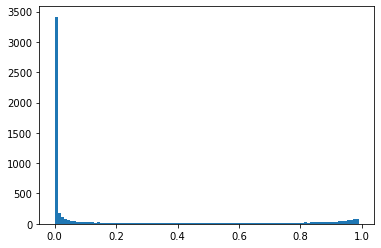

In [9]:
plt.hist(scouter.action, bins=100);

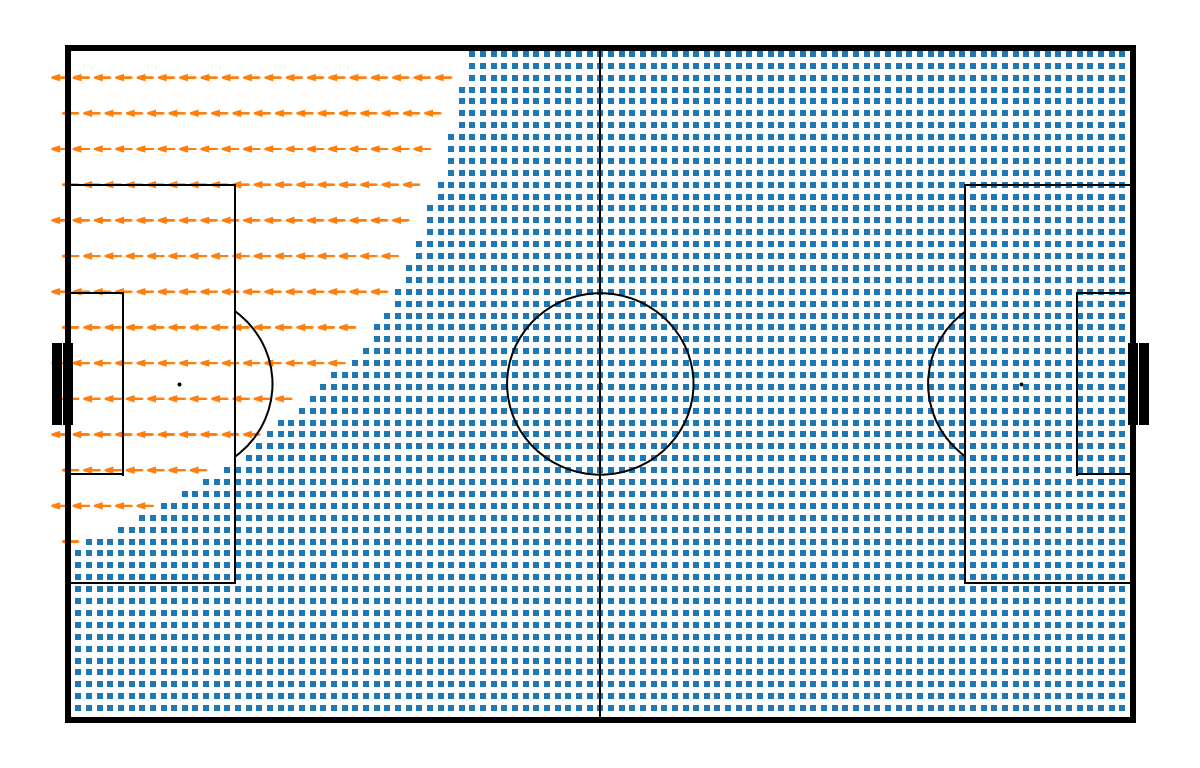

In [10]:
draw.pitch()
scouter_shots = scouter[scouter.action < 0.5]
scouter_passes = scouter[scouter.action >= 0.5]
plt.scatter(scouter_shots.x, scouter_shots.y, s = 10, c = 'C0', marker = 's', linewidth=0);
for i, row in scouter_passes.iterrows():
    if i%6 == 0:
        plt.arrow(row['x'], row['y'], 1.5*row.r/abs(row.r) * np.cos((row.a - 0.5) * 2 * np.pi), 1.5*row.r/abs(row.r) * np.sin((row.a - 0.5) * 2 * np.pi), length_includes_head = True, head_width = .7, head_length = .7, color = 'C1')

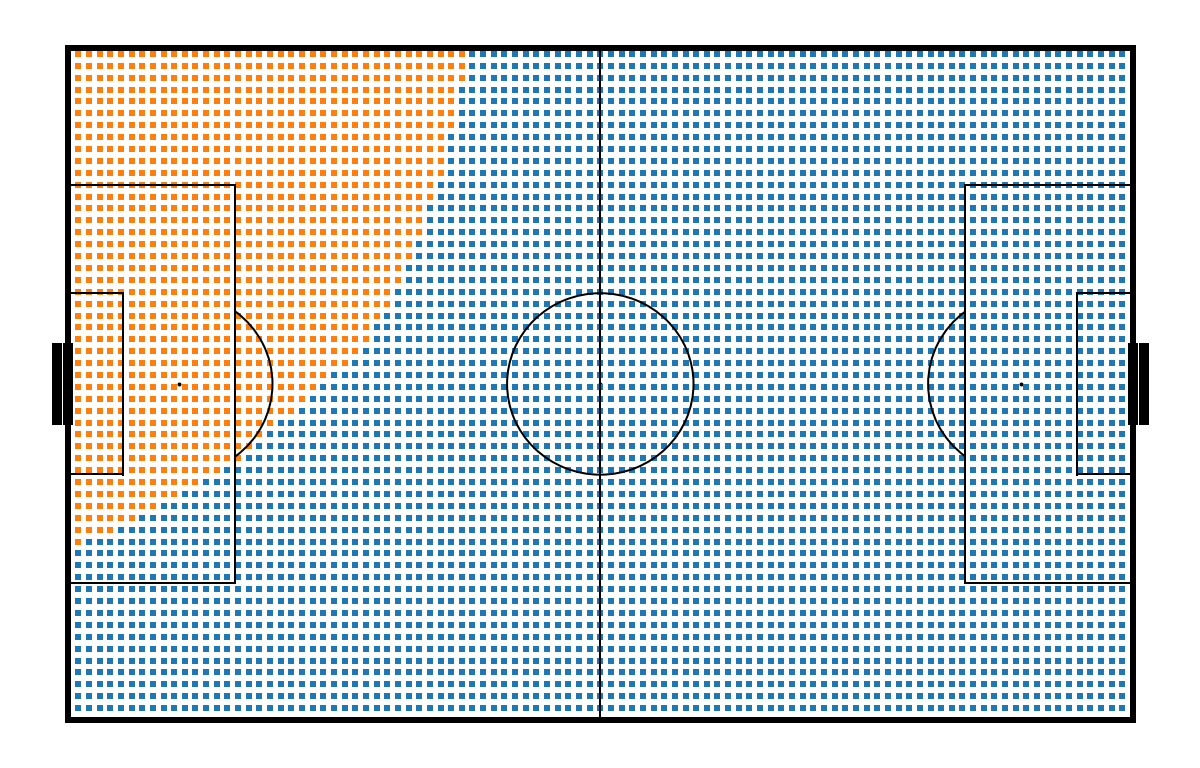

In [11]:
draw.pitch()
scouter_shots = scouter[scouter.action < 0.5]
scouter_passes = scouter[scouter.action >= 0.5]
plt.scatter(scouter_shots.x, scouter_shots.y, s = 10, c = 'C0', marker = 's', linewidth=0);
plt.scatter(scouter_passes.x, scouter_passes.y, s = 10, c = 'C1', marker = 's', linewidth=0);

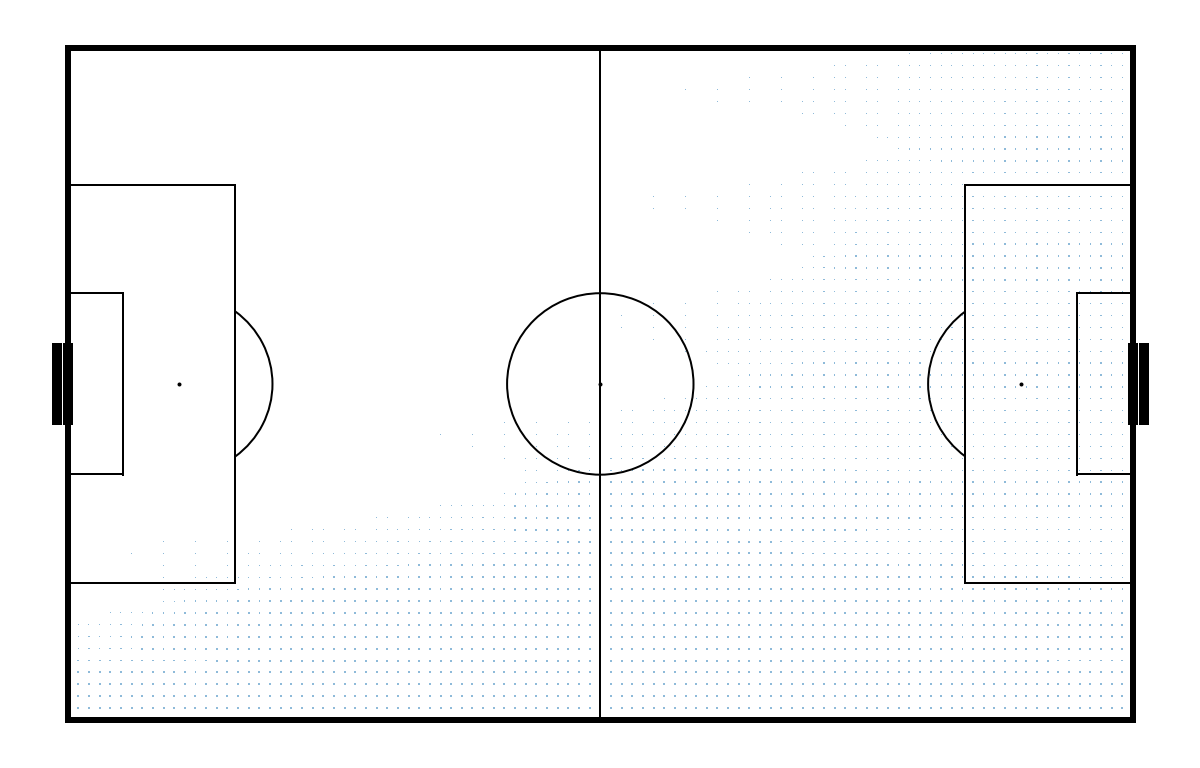

In [12]:
draw.pitch()
plt.scatter(scouter.x, scouter.y, s = scouter.r, c = 'C0', alpha = 0.5, marker = 's', linewidth=0);

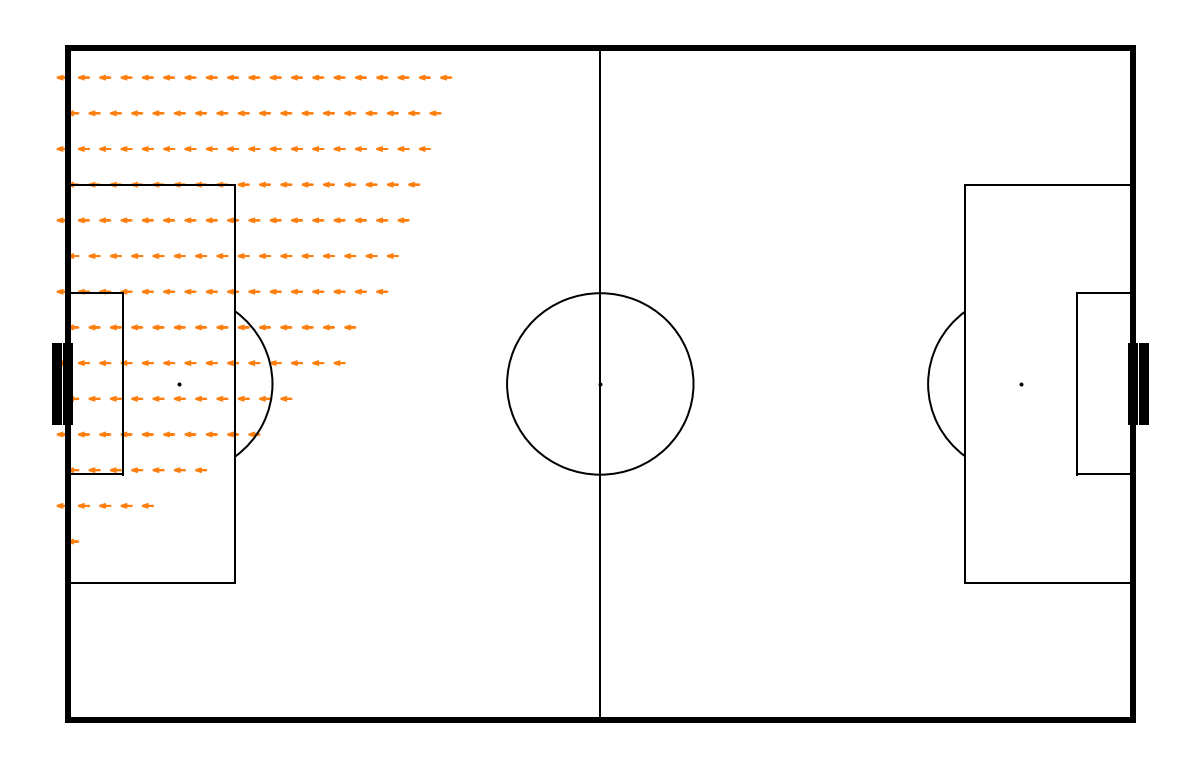

In [13]:
draw.pitch()
for i, row in scouter_passes.iterrows():
    if i%6 == 0:
        plt.arrow(row['x'], row['y'], row.r/abs(row.r) * np.cos((row.a - 0.5) * 2 * np.pi), row.r/abs(row.r) * np.sin((row.a - 0.5) * 2 * np.pi), length_includes_head = True, head_width = .5, head_length = .5, color = 'C1')